In [1]:
import HelperFuncs as hfuncs
import numpy as np

We're going to first try training a CNN on the individual images.
We will be using binary cross entropy across the 17 regions.

In [2]:
import HelperFuncs as hfuncs
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.data_utils import Sequence
import h5py
import os

BATCH_SIZE = 1
FINAL_WIDTH = 400
FINAL_HEIGHT = 600
CHANNELS = 1
ZONES = 17
ANGLES = 4
#Create directories for sequencer function if they don't exist
for d in ['temp/train_scan/','temp/test_scan/','temp/val_scan/']:
    if not os.path.isdir(d):
        print("Created directory: {}".format(d))
        os.makedirs(d)
        
class ScanSequencer(Sequence):
    idx_dict={}
    
    def __init__(self,num_batches,bucket_name,mode="train_scan"):
        self.num_batches = num_batches
        self.bucket_name = bucket_name
        self.mode = mode
        self.key_id, self.secret_key = hfuncs.GetAWSCredentials()
        self.mode = mode
        self.angles = np.arange(0,64,64//ANGLES)
    def __len__(self):
        return self.num_batches
    def on_epoch_end(self):
        pass
    def __getitem__(self,idx):
        #Get Client
        client = hfuncs.GetAWSClient(self.key_id,self.secret_key)
        bucket = client.Bucket(self.bucket_name)
        
        #Initialize vectors
        X_train = np.zeros((BATCH_SIZE,ANGLES,FINAL_WIDTH,FINAL_HEIGHT,CHANNELS))
        y_train = np.zeros((BATCH_SIZE,ZONES))
        
        j=0
        for i in range(idx*BATCH_SIZE,(idx+1)*BATCH_SIZE):
            #Download batch at index
            path = "temp/{}/batch_{}.hdf5".format(self.mode,i)
            key = "{}/batch_{}.hdf5".format(self.mode,i)
            bucket.download_file(Key=key,Filename=path)
        
            f = h5py.File(path,"r")
            try:
                X_train[j,:,:,:,:] = f['/image'].value[self.angles,:,:,:]
                y_train[j,:] = f['/labels'].value
                j += 1
            finally:
                f.close()
                os.remove(path) 
        return X_train, y_train
class LegScanSequencer(Sequence):
    idx_dict={}
    
    def __init__(self,num_batches,bucket_name,mode="train_scan"):
        self.num_batches = num_batches
        self.bucket_name = bucket_name
        self.mode = mode
        self.key_id, self.secret_key = hfuncs.GetAWSCredentials()
        self.mode = mode
        self.angles = np.arange(0,64,64//ANGLES)
    def __len__(self):
        return self.num_batches
    def on_epoch_end(self):
        pass
    def __getitem__(self,idx):
        #Get Client
        client = hfuncs.GetAWSClient(self.key_id,self.secret_key)
        bucket = client.Bucket(self.bucket_name)
        
        #Initialize vectors
        X_train = np.zeros((BATCH_SIZE,ANGLES,FINAL_WIDTH,FINAL_HEIGHT//2,CHANNELS))
        y_train = np.zeros((BATCH_SIZE,1))
        
        j=0
        for i in range(idx*BATCH_SIZE,(idx+1)*BATCH_SIZE):
            #Download batch at index
            path = "temp/{}/batch_{}.hdf5".format(self.mode,i)
            key = "{}/batch_{}.hdf5".format(self.mode,i)
            bucket.download_file(Key=key,Filename=path)
        
            f = h5py.File(path,"r")
            try:
                X_train[j,:,:,:,:] = f['/image'].value[self.angles,:,:FINAL_HEIGHT//2,:]
                r_leg = [12,14,13,15]
                l_leg = [13,15]
                r_y = np.amax(f['/labels'].value[r_leg])
                #l_y = np.amax(f['/labels'].value[l_leg])
                y_train[j,:] = r_y
                j += 1
            finally:
                f.close()
                os.remove(path) 
        return X_train, y_train



Using TensorFlow backend.


In [3]:
from twilio.rest import Client
import configparser
from keras.callbacks import Callback

class SMSNotifier(Callback):
    def on_epoch_end(self,epoch,logs=None):
        #Execute every other epoch
        if epoch % 2 == 0:
            #Get config credentials
            config = configparser.ConfigParser()
            config.read('twilio.conf')
            account_sid = config['DEFAULT']['AccountID']
            auth_token = config['DEFAULT']['AuthToken']
            #Get client
            client = Client(account_sid, auth_token)
            #Create message
            if logs is not None:
                message = "Epoch {} complete. Loss: {} Val_loss: {} ".format(epoch,
                                                                             logs.get('loss'),
                                                                             logs.get('val_loss'))
            else:
                message = "Epoch {} complete. No loss data available.".format(epoch)
            #Sendmessage
            message = client.messages.create(
                to="+16178884129", 
                from_="+18572142288",
                body=message)
        else:
            pass

In [4]:
from keras import backend as K
import tensorflow as tf
from keras.losses import binary_crossentropy

def weighted_binary_crossentropy(y_true, y_pred):
    x = 0.18 #Approximate percentage of positives in each of the 17 zones
    POS_ADJ = 0.5/x
    NEG_ADJ = 0.5/(1-x)
    n_values = BATCH_SIZE
    elems = (tf.unstack(y_true,num=n_values,axis=0)) 
    adj = tf.map_fn(lambda x:tuple([tf.cond(tf.equal(x[i],1.),lambda:POS_ADJ,lambda: NEG_ADJ) for i in range(n_values)]),
                    elems, 
                    dtype = tuple([tf.float32 for i in range(n_values)]) )
    adj = tf.stack(adj,axis=0)
    return K.mean(tf.multiply(adj,K.binary_crossentropy(y_true,y_pred)),axis=-1)


In [21]:
#Build pre-trained V2 model
import numpy as np
from keras.layers import Input,Flatten,Dense,Concatenate,Dropout,concatenate,GlobalMaxPool2D
from keras.models import Model
from datetime import datetime
from keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam,SGD
from keras.metrics import binary_accuracy
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.losses import binary_crossentropy
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.layers.core import Lambda
import tensorflow as tf

def ToRGB(x):
    max_v = tf.reduce_max(x)
    min_v = tf.reduce_min(x)
    max_rgb = tf.constant(255,dtype=x.dtype)
    min_rgb = tf.constant(255//2,dtype=x.dtype)
    x = tf.add(tf.floordiv(tf.multiply(tf.subtract(x,min_v),tf.subtract(max_rgb,min_rgb)),tf.subtract(max_v,min_v)),min_rgb)
    return x
def ToGreyScale(x):
    #Divide RGB into 3
    scalar = tf.constant(3,dtype=x.dtype)
    #scalar2 = tf.constant(85,dtype=x.dtype)
    #x = tf.floordiv(x,scalar)
    #x = tf.add(x,scalar2)
    shape = x.get_shape()
    #assume channel_last
    mult = [[1 for d in shape[:-1]],[3]]
    mult = [val for sublist in mult for val in sublist]
    return tf.tile(x,mult)
def ToNewShape(x):
    ndim = len(x.shape)
    if ndim == 5:
        return tf.reverse(tf.transpose(x,[0,1,3,2,4]),[-3])
    elif ndim == 4:
        return tf.reverse(tf.transpose(x,[0,2,1,3]),[-3])
    else:
        raise ValueError("Unexpected number of dims!")

def getSingleLegModel(lstm_dim=5):
    #Single model image
    input_img = Input(shape=(FINAL_WIDTH,FINAL_HEIGHT//2,CHANNELS))
    
    #preprocess and extract channels
    input_img_pp = Lambda(ToRGB)(input_img)
    input_img_pp = Lambda(ToGreyScale)(input_img_pp)
    input_img_pp = Lambda(preprocess_input)(input_img_pp)
    input_img_pp = Lambda(ToNewShape)(input_img_pp)
    
    #Load resnet
    #incep = InceptionV3(include_top=False,
        #                  weights='imagenet',
       #                   input_tensor=None,
     #                     input_shape=(FINAL_HEIGHT//2,FINAL_WIDTH,3),
      #                    pooling='max')
    #for l in incep.layers:
     #   l.trainable=False

    #Take off top
    #reduced_net = Model(incep.input,incep.get_layer('mixed5').output)
    #output = reduced_net(input_img_pp)
    #intermediate_model = Model(input_img,output)
    
    #Time distributed model
    #input_scan = Input(shape=(ANGLES,FINAL_WIDTH,FINAL_HEIGHT//2,CHANNELS))  
    #sequenced_model = TimeDistributed(intermediate_model)(input_scan)
  
    #One lstm layer for now
    #lstm = LSTM(lstm_dim,recurrent_dropout=0.10)(sequenced_model)
    
    #Finally, 1 dense layers
    #out = Dense(1,activation='sigmoid',use_bias=False)(lstm)
    #complete model
    try:
        return Model(input_scan,sequenced_model)#Model(input_scan, out)
    finally:
        del intermediate_model,sequenced_model,incep
        



In [147]:
incep = InceptionV3(include_top=False,
                          weights=None,
                          input_tensor=None,
                          input_shape=(FINAL_HEIGHT//2,FINAL_WIDTH,3),
                          pooling='max')
for i in range(11):
    print('mixed{}'.format(i),incep.get_layer('mixed{}'.format(i)).output_shape[-3:]," {}".format(np.prod(incep.get_layer('mixed{}'.format(i)).output_shape[-3:])))

mixed0 (35, 47, 256)  421120
mixed1 (35, 47, 288)  473760
mixed2 (35, 47, 288)  473760
mixed3 (17, 23, 768)  300288
mixed4 (17, 23, 768)  300288
mixed5 (17, 23, 768)  300288
mixed6 (17, 23, 768)  300288
mixed7 (17, 23, 768)  300288
mixed8 (8, 11, 1280)  112640
mixed9 (8, 11, 2048)  180224
mixed10 (8, 11, 2048)  180224


In [12]:
from matplotlib import pyplot as plt
%matplotlib inline
#Generators and fit
print("Initializing generators...")
#Bucket with clean data
UPLOAD_BUCKET = 'cleandhsdata' #bucket where clean data was stored
key_id, secret_key = hfuncs.GetAWSCredentials()
client = hfuncs.GetAWSClient(key_id,secret_key)
bucket = client.Bucket(UPLOAD_BUCKET)

#Initialize train sequencer
mode ="train_scan"
num_batches_train = (sum([1 if "{}/".format(mode) in k.key else 0 for k in bucket.objects.all()])-1)//BATCH_SIZE #train,test,val root directories have their own keys
#num_batches = 660//BATCH_SIZE
train_seq = LegScanSequencer(num_batches_train,UPLOAD_BUCKET,mode=mode)

for X, y in train_seq:
    if np.amax(y) == 1:
        break
        


#slm = getSingleLegModel()


Initializing generators...


Actual y:
[[ 1.]]


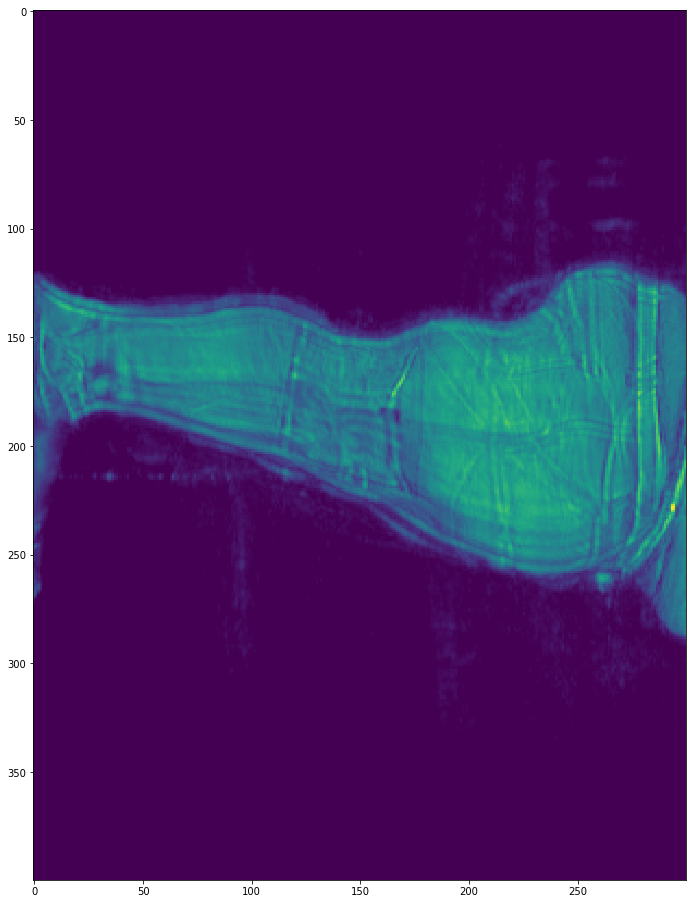

In [16]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(111)
ax.imshow(X[0,3,:,:,0], cmap = 'viridis')

print("Actual y:")
print(y)

In [ ]:
sess = tf.InteractiveSession()
z = weighted_binary_crossentropy(tf.convert_to_tensor(y,dtype=tf.float32),tf.convert_to_tensor([[0.]],dtype=tf.float32))
print(z.eval())
print("Expected:{}".format(-0.5/0.1*1*np.log(0.5)))

In [22]:
#Test modelchanges
sess = tf.InteractiveSession()
input_img = Input(shape=(FINAL_WIDTH,FINAL_HEIGHT//2,CHANNELS))

#preprocess and extract channels
input_img_pp = Lambda(ToRGB)(input_img)
input_img_pp = Lambda(ToGreyScale)(input_img_pp)
input_img_pp = Lambda(preprocess_input)(input_img_pp)
input_img_pp = Lambda(ToNewShape)(input_img_pp)

model = Model(input_img,input_img_pp)
result = model.predict(X[:,0,:,:,:])

print(result.shape)



(1, 300, 400, 3)


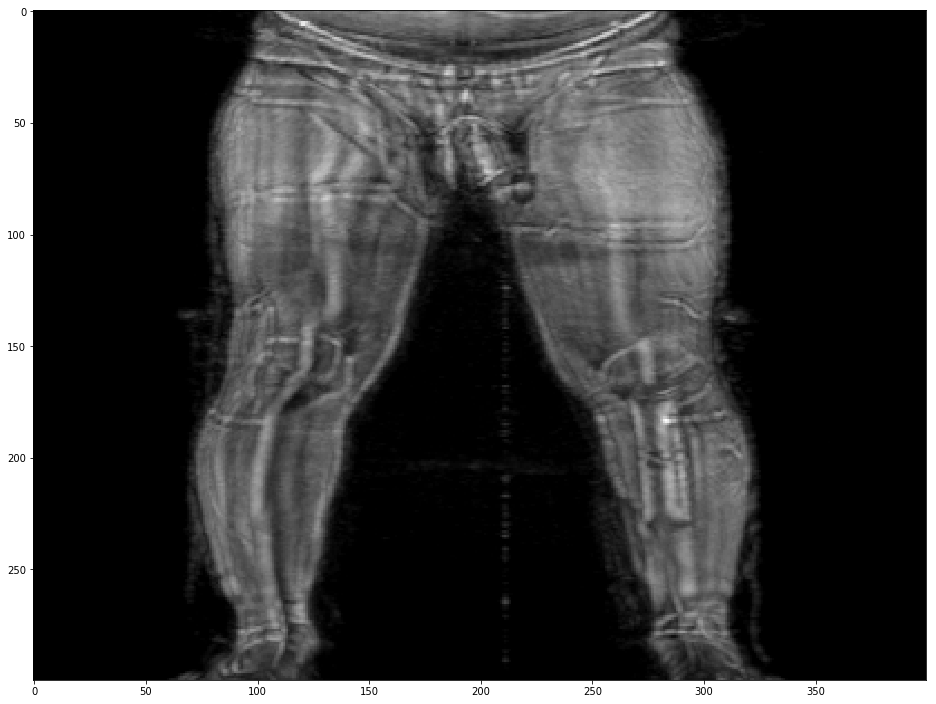

In [24]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(111)
ax.imshow(result[0,:,:,:])#, cmap = 'viridis')


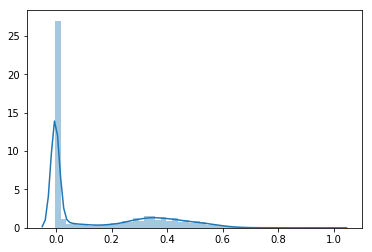

In [25]:
import seaborn as sns

sns.distplot(result.flatten())

In [40]:
#Test how many positive samples
import pickle
labels = hfuncs.GetLabelsDict(r'stage1_labels.csv')
filename = "data_separated.pickle"
with open(filename,"rb") as f:
   save = pickle.load(f)
   K_test= save['K_test']
   K_val = save['K_val']
   K_train = save['K_train']
s = 0
pos = 0
for k in K_train:
    k_clean = k.replace("DHSData/","").replace(".a3daps","")
    if k_clean in labels.keys():
        label = np.array(labels[k_clean])
        val = np.amax(label[[12,14,13,15]])
        if val == 1:
            s += 1
            pos += 1
        else:
            s += 1
print("total={},pos={}".format(s,pos))

total=687,pos=235


In [16]:
from keras.models import load_model
lstm_dim = 10
recurrent_model = getSingleLegModel(lstm_dim)
for l in  recurrent_model.layers:
    print(l.trainable)
#recurrent_model = load_model('check_points/2017_9_26_21_ScanModel_00-0.70.hdf5')

Max pool output (?, ?)
False
True
True
True


In [ ]:
#optimizer
lr = 0.01
beta1 = 0.9
beta2 = 0.999
description = "Pretrained model"
print("Compiling model...")
adam = Adam(lr,beta_1=beta1,beta_2=beta2)
sgd = SGD(lr=lr,momentum=0.5,nesterov=True)
recurrent_model.compile(optimizer=sgd,
                          metrics=[binary_crossentropy],
                         loss= binary_crossentropy)

#Tensorboard
x = datetime.today()
stamp = "{}-{}-{}_{}:{}:{}_lr-{}_beta1-{}_beta2-{}_lstmDim-{}_ANG-{}_{}".format(x.year,x.month,
                                                     x.day,x.hour,x.minute,
                                                     x.second,lr,beta1,beta2,lstm_dim,ANGLES,description)
tensorboard = TensorBoard(log_dir="logs/{}".format(stamp),histogram_freq=0,batch_size=BATCH_SIZE,
                          write_grads=False,write_images=False)
#Model checkpoint
check_point_dir = 'check_points/'
if not os.path.isdir(check_point_dir):
    os.makedirs(check_point_dir)    
chkpt = ModelCheckpoint(os.path.join(check_point_dir,"{}_{}_{}_{}_".format(x.year,x.month,x.day,x.hour) + 
                                     "ScanModel_{epoch:02d}-{val_loss:.2f}.hdf5"),
                       monitor='val_binary_crossentropy',
                       verbose=1,
                       save_best_only=True)
#Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_binary_crossentropy',
                             factor=0.2,
                             patience=1,
                             verbose=1,
                             min_lr=0.0001,
                             cooldown = 4)
#Notifications
notify = SMSNotifier()

#Early stopping callback
estop = EarlyStopping(monitor='val_binary_crossentropy',min_delta=0.0001,patience=5)

#Generators and fit
print("Initializing generators...")
#Bucket with clean data
UPLOAD_BUCKET = 'cleandhsdata' #bucket where clean data was stored
key_id, secret_key = hfuncs.GetAWSCredentials()
client = hfuncs.GetAWSClient(key_id,secret_key)
bucket = client.Bucket(UPLOAD_BUCKET)

#Initialize train sequencer
mode ="train_scan"
num_batches_train = (sum([1 if "{}/".format(mode) in k.key else 0 for k in bucket.objects.all()])-1)//BATCH_SIZE #train,test,val root directories have their own keys
#num_batches = 660//BATCH_SIZE
train_seq = LegScanSequencer(num_batches_train,UPLOAD_BUCKET,mode=mode)
#Initialize validation sequencer
mode = "val_scan"
num_batches_val = (sum([1 if "{}/".format(mode) in k.key else 0 for k in bucket.objects.all()])-1)//BATCH_SIZE #train,test,val root directories have their own keys
val_seq = LegScanSequencer(num_batches_val,UPLOAD_BUCKET,mode=mode)



print("Beginning training...")

hist,model = recurrent_model.fit_generator(train_seq,
                                   steps_per_epoch=num_batches_train,
                                   #steps_per_epoch=5,
                                   epochs=100,
                                   validation_data = val_seq,
                                   validation_steps = num_batches_val,
                                   #validation_steps = 5,
                                   callbacks=[tensorboard,chkpt,reduce_lr,notify,estop],
                                  use_multiprocessing = True,workers=2)


Compiling model...
Initializing generators...
Beginning training...
Epoch 1/100
890/891 [============================>.] - ETA: 3s - loss: 0.7201 - binary_accuracy: 0.3910 - binary_crossentropy: 0.7423

Exception in thread Thread-48:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/multiprocessing/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/multiprocessing/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/multiprocessing/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/home/ubuntu/anaconda3/envs/DHSenv_3.5/lib/python3.5/multiprocessing/context.py", line 267, in _Popen
   

In [51]:
#Use model as a feature extractor and use traditional ML to sdeterine whther features have any predictive power
from keras import backend as K
K.set_learning_phase(0)
#Bucket with clean data
UPLOAD_BUCKET = 'cleandhsdata' #bucket where clean data was stored
key_id, secret_key = hfuncs.GetAWSCredentials()
client = hfuncs.GetAWSClient(key_id,secret_key)
bucket = client.Bucket(UPLOAD_BUCKET)

#Initialize train sequencer
mode ="train_scan"
num_batches_train = (sum([1 if "{}/".format(mode) in k.key else 0 for k in bucket.objects.all()])-1)//BATCH_SIZE #train,test,val root directories have their own keys
#num_batches = 660//BATCH_SIZE
train_seq = LegScanSequencer(num_batches_train,UPLOAD_BUCKET,mode=mode)

X, y = train_seq.__getitem__(0)
model = getSingleLegModel()

X_features = model.predict(X)

In [52]:
#Print feature shape
print(X_features.shape)
print(X_features[0,0,:25])
print(X_features.flatten().shape)
print(X_features.flatten()[:25])
print(y.shape)

(1, 4, 3616)
[ 3.33088589  2.70432806  2.62582874  3.82342696  3.29325056  2.54281545
  5.46271992  5.17399263  3.81268978  1.74472094  2.69779372  3.19175076
  3.37660718  2.25403261  1.89083993  2.73238802  5.66918564  2.8287735
  3.53313351  1.97387779  2.5664115   2.06497645  3.53063083  6.02919674
  5.66571617]
(14464,)
[ 3.33088589  2.70432806  2.62582874  3.82342696  3.29325056  2.54281545
  5.46271992  5.17399263  3.81268978  1.74472094  2.69779372  3.19175076
  3.37660718  2.25403261  1.89083993  2.73238802  5.66918564  2.8287735
  3.53313351  1.97387779  2.5664115   2.06497645  3.53063083  6.02919674
  5.66571617]
(1, 1)


In [53]:
#Now loop through 200 images and 
X_train = np.zeros((800,3616*4))
y_train = np.zeros((800))

#Choose 300 immages randomly
order = np.random.choice(np.arange(num_batches_train),800)

i=0 #Pointer for final dataset
for b in order:
    X,y = train_seq.__getitem__(b)
    X = model.predict(X)
    X_train[i,:] = X.flatten()
    y_train[i] = y[0,0]
    print("Finished item {}".format(i))
    i += 1
    


    

Finished item 0
Finished item 1
Finished item 2
Finished item 3
Finished item 4
Finished item 5
Finished item 6
Finished item 7
Finished item 8
Finished item 9
Finished item 10
Finished item 11
Finished item 12
Finished item 13
Finished item 14
Finished item 15
Finished item 16
Finished item 17
Finished item 18
Finished item 19
Finished item 20
Finished item 21
Finished item 22
Finished item 23
Finished item 24
Finished item 25
Finished item 26
Finished item 27
Finished item 28
Finished item 29
Finished item 30
Finished item 31
Finished item 32
Finished item 33
Finished item 34
Finished item 35
Finished item 36
Finished item 37
Finished item 38
Finished item 39
Finished item 40
Finished item 41
Finished item 42
Finished item 43
Finished item 44
Finished item 45
Finished item 46
Finished item 47
Finished item 48
Finished item 49
Finished item 50
Finished item 51
Finished item 52
Finished item 53
Finished item 54
Finished item 55
Finished item 56
Finished item 57
Finished item 58
Finishe

Finished item 462
Finished item 463
Finished item 464
Finished item 465
Finished item 466
Finished item 467
Finished item 468
Finished item 469
Finished item 470
Finished item 471
Finished item 472
Finished item 473
Finished item 474
Finished item 475
Finished item 476
Finished item 477
Finished item 478
Finished item 479
Finished item 480
Finished item 481
Finished item 482
Finished item 483
Finished item 484
Finished item 485
Finished item 486
Finished item 487
Finished item 488
Finished item 489
Finished item 490
Finished item 491
Finished item 492
Finished item 493
Finished item 494
Finished item 495
Finished item 496
Finished item 497
Finished item 498
Finished item 499
Finished item 500
Finished item 501
Finished item 502
Finished item 503
Finished item 504
Finished item 505
Finished item 506
Finished item 507
Finished item 508
Finished item 509
Finished item 510
Finished item 511
Finished item 512
Finished item 513
Finished item 514
Finished item 515
Finished item 516
Finished i

In [54]:
print(X_train[10,:25])
print(y_train[:10])
print("There are {} samples and {} positive samples".format(len(y_train),sum(y_train)))

[ 3.4254458   2.70432806  2.62582874  3.84172773  3.21961713  2.66281199
  5.17096567  3.57096696  3.99469948  2.03853989  2.59845424  2.72419643
  2.7437644   1.89163327  1.89083993  2.73238802  6.35375214  2.96707773
  3.88169098  1.98781335  2.82380462  2.07882714  2.8122406   5.83004808
  5.04914093]
[ 0.  0.  0.  1.  1.  0.  0.  0.  0.  0.]
There are 800 samples and 273.0 positive samples


In [32]:
#Initialize validation sequencer
mode = "val_scan"
num_batches_val = (sum([1 if "{}/".format(mode) in k.key else 0 for k in bucket.objects.all()])-1)//BATCH_SIZE #train,test,val root directories have their own keys
val_seq = LegScanSequencer(num_batches_val,UPLOAD_BUCKET,mode=mode)

#Now loop through 50 val images  
X_val = np.zeros((100,3616*4))
y_val = np.zeros((100))

#Choose 300 immages randomly
order = np.random.choice(np.arange(num_batches_val),100)

i=0 #Pointer for final dataset
for b in order:
    X,y = val_seq.__getitem__(b)
    X = model.predict(X)
    X_val[i,:] = X.flatten()
    y_val[i] = y[0,0]
    print("Finished item {}".format(i))
    i += 1
    

Finished item 0
Finished item 1
Finished item 2
Finished item 3
Finished item 4
Finished item 5
Finished item 6
Finished item 7
Finished item 8
Finished item 9
Finished item 10
Finished item 11
Finished item 12
Finished item 13
Finished item 14
Finished item 15
Finished item 16
Finished item 17
Finished item 18
Finished item 19
Finished item 20
Finished item 21
Finished item 22
Finished item 23
Finished item 24
Finished item 25
Finished item 26
Finished item 27
Finished item 28
Finished item 29
Finished item 30
Finished item 31
Finished item 32
Finished item 33
Finished item 34
Finished item 35
Finished item 36
Finished item 37
Finished item 38
Finished item 39
Finished item 40
Finished item 41
Finished item 42
Finished item 43
Finished item 44
Finished item 45
Finished item 46
Finished item 47
Finished item 48
Finished item 49


In [55]:
print(X_val[10,:25])
print(y_val[:10])
print("There are {} samples and {} positive samples".format(len(y_val),sum(y_val)))

[ 1.51906478  1.71466041  2.58287406  3.55267239  2.03162837  2.43047571
  2.10054326  1.9151516   2.07664919  1.9912008   1.41460013  1.92593861
  1.22342277  1.50722814  1.58543491  1.15811348  2.97218847  2.48586178
  2.61074829  2.49935579  1.36995602  2.25530648  0.35478419  3.44668198
  1.9109304 ]
[ 0.  1.  1.  1.  1.  1.  1.  0.  1.  0.]
There are 50 samples and 24.0 positive samples


In [56]:
import pickle

save = {'X_train':X_train,'y_train':y_train}
with open("transformed_X.pickle",'wb') as f:
    pickle.dump(save,f)

In [121]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss,make_scorer
from sklearn.model_selection import RandomizedSearchCV

#Scorer
log_loss_scorer = make_scorer(log_loss,greater_is_better=False,needs_proba=True)

#Classifier
clf = GradientBoostingClassifier(min_samples_split=3,max_depth=5,learning_rate=0.05,n_estimators=100)
param_grid = {'subsample':[0.20,0.40,0.60,0.80,1],
             'min_samples_split':[2,5,8],
             'min_samples_leaf':[1,5,10]}
rans = RandomizedSearchCV(clf,param_grid,n_iter=20,scoring=log_loss_scorer,cv=3,random_state=0,verbose=2,n_jobs=4)
rans.fit(X_train,y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] min_samples_leaf=10, min_samples_split=2, subsample=0.2 .........
[CV] min_samples_leaf=10, min_samples_split=2, subsample=0.2 .........
[CV] min_samples_leaf=10, min_samples_split=2, subsample=0.2 .........
[CV] min_samples_leaf=10, min_samples_split=5, subsample=0.6 .........
[CV]  min_samples_leaf=10, min_samples_split=2, subsample=0.2, total=  24.3s
[CV] min_samples_leaf=10, min_samples_split=5, subsample=0.6 .........
[CV]  min_samples_leaf=10, min_samples_split=2, subsample=0.2, total=  24.1s
[CV] min_samples_leaf=10, min_samples_split=5, subsample=0.6 .........
[CV]  min_samples_leaf=10, min_samples_split=2, subsample=0.2, total=  24.8s
[CV] min_samples_leaf=5, min_samples_split=8, subsample=0.6 ..........
[CV]  min_samples_leaf=10, min_samples_split=5, subsample=0.6, total= 1.2min
[CV] min_samples_leaf=5, min_samples_split=8, subsample=0.6 ..........
[CV]  min_samples_leaf=10, min_samples_split=5, subsample=0.6, 

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 10.7min


[CV]  min_samples_leaf=5, min_samples_split=5, subsample=0.2, total=  32.0s
[CV] min_samples_leaf=10, min_samples_split=8, subsample=0.4 .........
[CV]  min_samples_leaf=5, min_samples_split=8, subsample=1, total= 2.2min
[CV] min_samples_leaf=10, min_samples_split=8, subsample=0.4 .........
[CV]  min_samples_leaf=5, min_samples_split=8, subsample=1, total= 2.2min
[CV] min_samples_leaf=1, min_samples_split=2, subsample=0.6 ..........
[CV]  min_samples_leaf=10, min_samples_split=8, subsample=0.4, total=  49.7s
[CV] min_samples_leaf=1, min_samples_split=2, subsample=0.6 ..........
[CV]  min_samples_leaf=10, min_samples_split=8, subsample=0.4, total=  49.9s
[CV] min_samples_leaf=1, min_samples_split=2, subsample=0.6 ..........
[CV]  min_samples_leaf=10, min_samples_split=8, subsample=0.4, total=  49.5s
[CV] min_samples_leaf=10, min_samples_split=8, subsample=0.8 .........
[CV]  min_samples_leaf=1, min_samples_split=2, subsample=0.6, total= 1.7min
[CV] min_samples_leaf=10, min_samples_split

[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 18.2min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=4,
          param_distributions={'min_samples_leaf': [1, 5, 10], 'min_samples_split': [2, 5, 8], 'subsample': [0.2, 0.4, 0.6, 0.8, 1]},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score=True,
          scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
          verbose=2)

In [123]:
#with open("param_test.pickle","wb")as f:
#    pickle.dump(rans.cv_results_,f)

print(rans.cv_results_['params'])
#print(rans.cv_results_['mean_fit_time'][9])
print(rans.cv_results_['mean_test_score'])
print(rans.cv_results_['std_test_score'])
print(rans.cv_results_['mean_train_score'])
#print(rans.cv_results_['std_train_score'])
print(max(rans.cv_results_['mean_test_score']))

#tclf = GradientBoostingClassifier(max_depth=20, learning_rate=0.4, n_estimators=25)
#tclf.fit(X_train[:700],y_train[:700])

print(log_loss_scorer(tclf,X_train[700:800],y_train[700:800]))

[{'min_samples_leaf': 10, 'min_samples_split': 2, 'subsample': 0.2}, {'min_samples_leaf': 10, 'min_samples_split': 5, 'subsample': 0.6}, {'min_samples_leaf': 5, 'min_samples_split': 8, 'subsample': 0.6}, {'min_samples_leaf': 1, 'min_samples_split': 2, 'subsample': 1}, {'min_samples_leaf': 1, 'min_samples_split': 8, 'subsample': 0.2}, {'min_samples_leaf': 5, 'min_samples_split': 8, 'subsample': 0.2}, {'min_samples_leaf': 5, 'min_samples_split': 8, 'subsample': 0.8}, {'min_samples_leaf': 1, 'min_samples_split': 8, 'subsample': 0.4}, {'min_samples_leaf': 10, 'min_samples_split': 5, 'subsample': 0.8}, {'min_samples_leaf': 10, 'min_samples_split': 2, 'subsample': 0.4}, {'min_samples_leaf': 5, 'min_samples_split': 8, 'subsample': 1}, {'min_samples_leaf': 5, 'min_samples_split': 5, 'subsample': 0.2}, {'min_samples_leaf': 10, 'min_samples_split': 8, 'subsample': 0.4}, {'min_samples_leaf': 1, 'min_samples_split': 2, 'subsample': 0.6}, {'min_samples_leaf': 10, 'min_samples_split': 8, 'subsample'

In [116]:
print(rans.best_params_)
clf = GradientBoostingClassifier(max_depth=5,learning_rate=0.05,n_estimators=100,subsample = 0.60)
clf.fit(X_train[:700,:],y_train[:700])

pred_train = clf.predict_proba(X_train[:700,:])
pred_val = clf.predict_proba(X_train[700:800,:])

train_loss = log_loss(y_train[:700],pred_train)
val_loss = log_loss(y_train[700:800],pred_val)

print("Train loss:{}".format(train_loss))
print("Val loss:{}".format(val_loss))

{'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 100}
Train loss:0.05195970005566199
Val loss:0.33205326449110883


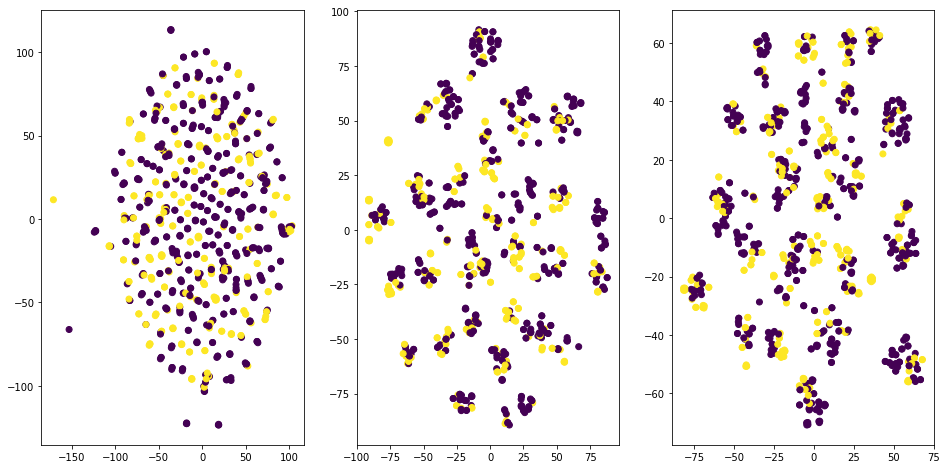

In [68]:
#Visualize data set using tsne
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
%matplotlib inline

fig, subplots = plt.subplots(1,3,figsize = (16,8))
perp = [1,5,10]
i=0
for p in perp:
    tsne = TSNE(random_state=0,perplexity=p)
    Y = tsne.fit_transform(X_train)
    ax = subplots[i]
    ax.scatter(Y[:,0],Y[:,1],c=y_train)
    i += 1
